In [105]:
import d2l
import torch
import matplotlib
from httpx import patch
from torch import nn
import torch.nn.functional as F
import torchvision
from webcolors import names

In [136]:
class BCE_IoU_Loss(nn.Module):
    """
    损失函数 L_total = L_BCE + L_IoU
    """
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth  # 平滑项
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        # BCE损失
        bce_loss = self.bce(pred, target)

        # IoU损失
        pred_flat = pred.view(pred.size(0), -1)
        target_flat = target.view(target.size(0), -1)


        # 计算每个图像的交集和并集
        intersection = torch.sum(pred_flat * target_flat, dim=1)
        union = torch.sum(pred_flat + target_flat - pred_flat * target_flat, dim=1)

        # 计算平均 IoU 并返回损失
        iou = torch.mean((intersection + self.smooth) / (union + self.smooth))
        iou_loss = 1 - iou

        # 组合损失
        total_loss = bce_loss + iou_loss
        return total_loss, iou

In [107]:
# 获得编码器的预训练版本
import local_clip
import os
import torch
from pycocotools.coco import COCO
from PIL import Image

device = "mps" if torch.mps.is_available() else "cpu"
encoder, preprocess = local_clip.load("ViT-B/16", device=device)

image = preprocess(Image.open("../cocoseg/train2017/000000000009.jpg")).unsqueeze(0).to(device)

# 我们修改了 local_clip，使得 encode_image 可以返回 ViT 所有 transformer 层的 feature_map
with torch.no_grad():
    image_feature, feature_maps = encoder.encode_image(image)

# 特征向量
print(image_feature.shape)
# Transformer 特征图
# [batch_size=1, layer=K=12, Patches=(224/16)^2+1=197, width=768]
print(feature_maps.shape)

torch.Size([1, 512])
torch.Size([1, 12, 197, 768])


In [108]:
import numpy as np
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

class CocoSegDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        """
        为COCO-SEG 数据集给出了简单通用的读取接口

        Args:
            root_dir (str): 根目录（包含 train2017/val2017）
            ann_file (str): COCO标注文件路径
            transform (callable, optional): 数据增强变换
        """
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)

        # 获取所有有效的图像ID
        self.img_ids = self.coco.getImgIds()

        # 加载类别信息
        self.categories = self.coco.loadCats(self.coco.getCatIds())
        self.cat_ids = self.coco.getCatIds()
        self.cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(self.cat_ids)}
        self.cat_names = [cat['name'] for cat in self.categories]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        """
        根据图像 idx 返回图像信息
        """
        # 获取图像ID和信息根据
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]

        # 加载图像
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        orig_size = image.size

        # 加载标注
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # 创建掩码和标签
        masks = []
        labels = []
        for ann in anns:
            mask = self.coco.annToMask(ann)
            cat_idx = self.cat_id_to_idx[ann['category_id']]
            masks.append(mask)
            labels.append(cat_idx)

        # 确保至少有一个实例
        if not masks:
            masks = [np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)]
            labels = [0]

        # 转换为numpy数组
        masks = np.stack(masks, axis=0)
        labels = np.array(labels, dtype=np.int64)

        # 数据转换
        if self.transform is not None:
            image = self.transform(image)
            masks = torch.from_numpy(masks)
            if image.shape[-2:] != masks.shape[-2:]:
                masks = F.interpolate(
                    masks.unsqueeze(0).float(),
                    size=image.shape[-2:],
                    mode='nearest'
                ).squeeze(0)
        else:
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
            masks = torch.from_numpy(masks)

        labels = torch.from_numpy(labels)

        return {
            'image': image,
            'mask': masks,
            'label': labels,
            'img_id': img_id,
            'orig_size': orig_size
        }

    def get_cat_name(self, cat_idx):
        return self.cat_names[cat_idx]

    def __repr__(self):
        return f"CocoSegDataset(num_images={len(self)}, num_categories={len(self.cat_ids)})"

    def get_category_image_ids(self, category_name=None):
        """
        获取指定类别的所有图像ID（懒加载方式）
        如果category_name为None，则返回所有图像ID

        Args:
            category_name (str, optional): 类别名称，默认为None

        Returns:
            list: 包含图像的ID列表
        """
        # 如果category_name为None，返回所有图像ID
        if category_name is None:
            # 确保返回的ID都是有效的
            valid_img_ids = []
            for img_id in self.img_ids:
                img_info = self.coco.loadImgs(img_id)
                if img_info is not None and len(img_info) > 0:
                    valid_img_ids.append(img_id)

            print(f"返回所有有效图像，共 {len(valid_img_ids)} 张")
            return valid_img_ids

        # 获取类别ID
        cat_idx = self.cat_names.index(category_name) if category_name in self.cat_names else -1
        if cat_idx == -1:
            print(f"类别 '{category_name}' 不存在，可用类别: {self.cat_names}")
            return []

        cat_id = self.cat_ids[cat_idx]

        # 获取包含该类别的图像ID
        img_ids = self.coco.getImgIds(catIds=[cat_id])

        # 验证这些ID是否有效
        valid_img_ids = []
        for img_id in img_ids:
            img_info = self.coco.loadImgs(img_id)
            if img_info is not None and len(img_info) > 0:
                valid_img_ids.append(img_id)

        print(f"找到 {len(valid_img_ids)} 个包含类别 '{category_name}' 的有效图像")
        return valid_img_ids

    def get_category_sample(self, img_id, category_name):
        """
        根据图像ID和类别名称获取样本

        Args:
            img_id (int): 图像ID
            category_name (str): 类别名称

        Returns:
            dict: 包含图像和对应掩码的样本
        """
        # 获取类别ID
        cat_idx = self.cat_names.index(category_name) if category_name in self.cat_names else -1
        if cat_idx == -1:
            print(f"类别 '{category_name}' 不存在，可用类别: {self.cat_names}")
            return None

        cat_id = self.cat_ids[cat_idx]

        # 获取图像信息
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])

        # 检查文件是否存在
        if not os.path.exists(img_path):
            print(f"图像文件不存在: {img_path}")
            return None

        # 加载图像
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"无法打开图像 {img_path}: {e}")
            return None

        # 获取该类别的标注
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=[cat_id])
        anns = self.coco.loadAnns(ann_ids)

        # 创建该类别的掩码
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.logical_or(mask, self.coco.annToMask(ann))

        # 应用变换
        if self.transform is not None:
            transformed_image = self.transform(image)
            # 调整掩码大小以匹配变换后的图像
            mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()
            if transformed_image.shape[-2:] != mask_tensor.shape[-2:]:
                mask_tensor = F.interpolate(
                    mask_tensor.unsqueeze(0),
                    size=transformed_image.shape[-2:],
                    mode='nearest'
                ).squeeze(0)
        else:
            transformed_image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
            mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()

        return {
            'image': transformed_image,
            'mask': mask_tensor,
            'img_id': img_id,
            'orig_image': image,
            'orig_mask': mask
        }

In [109]:
class CategoryDataset(Dataset):
    def __init__(self, coco_dataset, category_name, max_samples=None):
        self.coco_dataset = coco_dataset
        self.category_name = category_name

        # 获取该类别的所有图像ID
        self.img_ids = coco_dataset.get_category_image_ids(category_name)

        # 限制样本数量
        if max_samples is not None and max_samples < len(self.img_ids):
            self.img_ids = self.img_ids[:max_samples]

        print(f"创建了包含{len(self.img_ids)}张'{category_name}'类别图像的数据集")

        # 添加转换器，确保返回张量
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        """懒加载方式获取样本"""
        img_id = self.img_ids[idx]
        sample = self.coco_dataset.get_category_sample(img_id, self.category_name)

        if sample is None:
            # 如果样本无效，尝试获取下一个样本
            print(f"警告：无法加载图像ID {img_id}，尝试使用替代样本")
            for i in range(1, min(10, len(self.img_ids))):
                alt_idx = (idx + i) % len(self.img_ids)
                alt_img_id = self.img_ids[alt_idx]
                alt_sample = self.coco_dataset.get_category_sample(alt_img_id, self.category_name)
                if alt_sample is not None:
                    sample = alt_sample
                    break

            if sample is None:
                raise RuntimeError(f"无法找到有效的替代样本，请检查数据集")

        # 确保所有返回的数据都是张量格式
        processed_sample = {}

        # 处理图像
        if 'image' in sample:
            if isinstance(sample['image'], torch.Tensor):
                processed_sample['image'] = sample['image']
            elif isinstance(sample['image'], np.ndarray):
                processed_sample['image'] = torch.from_numpy(sample['image'])
            else:  # PIL图像
                processed_sample['image'] = self.to_tensor(sample['image'])

        # 处理掩码
        if 'mask' in sample:
            if isinstance(sample['mask'], torch.Tensor):
                processed_sample['mask'] = sample['mask']
            elif isinstance(sample['mask'], np.ndarray):
                processed_sample['mask'] = torch.from_numpy(sample['mask']).float()
            else:  # PIL图像
                processed_sample['mask'] = self.to_tensor(sample['mask'])

        # 处理其他数据
        for key, value in sample.items():
            if key not in ['image', 'mask', 'orig_image', 'orig_mask']:
                processed_sample[key] = value

        # 确保img_id是标量
        processed_sample['img_id'] = int(img_id)

        return processed_sample

In [110]:
def _convert_image_to_rgb(image):
    return image.convert("RGB")

dataset_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    _convert_image_to_rgb,
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

train_dataset = CocoSegDataset(
    root_dir="../cocoseg/train2017",
    ann_file="../cocoseg/annotations/instances_train2017.json",
    transform=dataset_transforms
)

val_dataset = CocoSegDataset(
    root_dir="../cocoseg/val2017",
    ann_file="../cocoseg/annotations/instances_val2017.json",
    transform=dataset_transforms
)

loading annotations into memory...
Done (t=3.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [111]:
train_dataset.categories

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [112]:
import matplotlib
import matplotlib.pyplot as plt
import random

matplotlib.rcParams['font.family'] = ['Arial Unicode MS']

# # 创建可视化函数
def visualize_samples(dataset, idx_list, category, num_samples=5, random_choice=False):
    """
    可视化数据集中的样本
    """
    # 确保样本数量不超过可用ID数量
    num_samples = min(num_samples, len(idx_list))

    # 选择要显示的样本ID
    if random_choice:
        random.shuffle(idx_list)

    selected_idx = idx_list[:num_samples]

    # 计算有效样本数量
    valid_samples = []
    for img_id in selected_idx:
        if category is None:
            try:
                dataset.img_ids.index(img_id)
                valid_samples.append(img_id)
            except (ValueError, IndexError):
                continue
        else:
            sample = dataset.get_category_sample(img_id, category)
            if sample is not None:
                valid_samples.append(img_id)

    if not valid_samples:
        print("没有找到有效样本")
        return

    num_valid = len(valid_samples)

    # 创建图形和子图
    fig, axes = plt.subplots(num_valid, 3, figsize=(15, num_valid * 4))

    # 确保axes是二维的，即使只有一个样本
    if num_valid == 1:
        axes = np.array([axes])

    for i, img_id in enumerate(valid_samples):
        # 获取特定类别的样本
        sample = dataset.get_category_sample(img_id, category)
        if sample is None:
            continue

        # 绘制图像
        axes[i, 0].imshow(np.array(sample['orig_image']))
        axes[i, 0].set_title(f'图像 ID: {img_id}')
        axes[i, 0].axis('off')

        # 绘制掩码
        axes[i, 1].imshow(sample['orig_mask'], cmap='binary')
        axes[i, 1].set_title(f'类别: {category} 掩码')
        axes[i, 1].axis('off')

        # 显示原始图像和掩码叠加
        axes[i, 2].imshow(np.array(sample['orig_image']))
        axes[i, 2].imshow(sample['orig_mask'], alpha=0.5, cmap='cool')
        axes[i, 2].set_title('叠加效果')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [113]:
person_img_ids = train_dataset.get_category_image_ids("person")
visualize_samples(train_dataset, person_img_ids, category="person", num_samples=5, random_choice=True)

找到 64115 个包含类别 'person' 的有效图像


In [114]:
person_img_ids = train_dataset.get_category_image_ids("cake")
visualize_samples(train_dataset, person_img_ids, category="cake", num_samples=5, random_choice=True)

找到 2925 个包含类别 'cake' 的有效图像


In [115]:
class NaiveModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder, _ = local_clip.load("ViT-B/16")
        self.linear_dis = nn.Linear(512, 768).to(dtype=torch.float32)

        # 使用一系列转置卷积将 24*32 的图像扩展为 mask 的 224*224 大小
        self.transpose_conv_layers = nn.Sequential(
            # 第一层转置卷积，输入通道数和输出通道数均为 197，卷积核大小 4，步长 2，填充 1
            # 经过第一层图像扩大为 48*64
            nn.ConvTranspose2d(197, 197, kernel_size=4, stride=(2,2), padding=1),
            nn.BatchNorm2d(197),
            nn.ReLU(inplace=True),
            # 第二层转置卷积，卷积核大小 4，步长 2，填充 1
            # 经过第二层图像扩大为 96*128
            nn.ConvTranspose2d(197, 197, kernel_size=4, stride=(2,2), padding=1),
            nn.BatchNorm2d(197),
            nn.ReLU(inplace=True),
            # 第三层转置卷积，卷积核大小 4，步长 2，填充 1
            # 经过第三层图像扩大为 196*128
            nn.ConvTranspose2d(197, 197, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(197),
            nn.ReLU(inplace=True),
            # 第四层转置卷积，卷积核大小 4，步长 2，填充 1
            # 经过第四层图像扩大为 196*256
            nn.ConvTranspose2d(197, 197, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(197),

            # 裁剪层，将 (192, 256) 裁剪为 (224, 224)
            nn.Upsample(size=(224, 224), mode="bilinear", align_corners=True),
        ).to(dtype=torch.float32)

        self.conv = nn.Conv2d(197, 1, kernel_size=1, device=device).to(dtype=torch.float32)
        self.sigmoid = nn.Sigmoid()

        for param in self.parameters():
            param.requires_grad = True

    def init_weights(self):
        # 确保初始化的权重可求梯度
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                # 确保权重可求梯度
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.requires_grad = True
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                # 确保权重可求梯度
                m.weight.requires_grad = True
                m.bias.requires_grad = True
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                # 确保权重可求梯度
                m.weight.requires_grad = True
                m.bias.requires_grad = True

    def forward(self, images):
        """
        images: [batch_size, 3, 224, 224]
        v: [batch_size, 512]
        Fk: [K, batch_size, channels/Patched = 197, 768]
        """
        # encoder只接受dtype16
        v, Fk = self.encoder.encode_image(images.to(dtype=torch.float16))
        v.to(torch.float32)
        Fk.to(torch.float32)

        # 膜 2 正则化
        g = F.normalize(v, p=2, dim=1, eps=1e-5).mean(dim=0)
        g = self.linear_dis(g)

        Fk = Fk * g

        # 将ViT每层Transformer返回的768大小特征向量展平到 24*32
        Fk = Fk.reshape(Fk.shape[0], Fk.shape[1], Fk.shape[2], 24, 32)

        batch_size, layers, patches, height, width = Fk.shape
        Fk = Fk.reshape(batch_size * layers, patches, height, width)

        # 上采样到 224 * 224
        Fk = self.transpose_conv_layers(Fk)

        Fk = Fk.reshape(batch_size, layers, patches, 224, 224).sum(dim=1)

        Fk = self.sigmoid(self.conv(Fk))
        return Fk

In [116]:
import d2l

image = preprocess(Image.open("../cocoseg/train2017/000000000009.jpg")).unsqueeze(0).to(device)
model = NaiveModule()
model.init_weights()

device = d2l.try_gpu()

model.to(device)
result = model(image)
print(result.shape)

torch.Size([1, 1, 224, 224])


In [117]:
import torch
from torch.utils.data import Dataset, DataLoader
import threading
import queue
import time

class SimpleDataLoader:
    def __init__(self, dataset, batch_size=4, shuffle=True, num_workers=0):
        """
        简化版的数据加载器，直接使用PyTorch的DataLoader

        Args:
            dataset: 数据集实例
            batch_size: 批次大小
            shuffle: 是否打乱数据
            num_workers: 工作线程数
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

        # 创建标准DataLoader
        self.dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=False
        )

    def __iter__(self):
        """返回迭代器"""
        return iter(self.dataloader)

    def __next__(self):
        """获取下一个批次"""
        return next(iter(self))

    def __len__(self):
        """返回批次数量"""
        return len(self.dataloader)



def get_category_dataloader(coco_dataset, category_name, batch_size=4, shuffle=True,
                           num_workers=0, max_samples=None):
    """
    Args:
        coco_dataset: CocoSegDataset实例
        category_name: 要加载的类别名称
        batch_size: 批次大小
        shuffle: 是否打乱数据
        num_workers: 工作线程数
        max_samples: 最大样本数量
    """
    dataset = CategoryDataset(coco_dataset, category_name, max_samples)
    dataloader = SimpleDataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )

    return dataloader

In [118]:
# 使用迭代器方式获取批次
try:
    # 重新创建数据加载器，使用简化版的加载器，并设置num_workers=0避免多进程问题
    person_dataloader = get_category_dataloader(
        coco_dataset=train_dataset,
        category_name="person",
        batch_size=8,
        shuffle=True,
        num_workers=0  # 在Jupyter中设为0避免多进程问题
    )

    batch = next(iter(person_dataloader))
    print(f"成功获取批次，图像形状: {batch['image'].shape}")
except StopIteration:
    print("数据集为空或无法加载数据")
except Exception as e:
    print(f"获取批次时发生错误: {e}")

找到 64115 个包含类别 'person' 的有效图像
创建了包含64115张'person'类别图像的数据集
成功获取批次，图像形状: torch.Size([8, 3, 224, 224])


In [119]:
results = model(batch['image'].to(device))
print(results.shape)

torch.Size([8, 1, 224, 224])


In [137]:
# 考虑到样本量较小，学习率取论文的30倍
encoder_lr = 9e-5
other_lr = 9e-4

def train_model(model, train_dataloader, val_dataloader,
                num_epochs=10,):
    """
    Args:
        model: 要训练的模型
        train_dataloader: 训练数据加载器
        val_dataloader: 验证数据加载器
        num_epochs: 训练轮数
    """
    device = d2l.try_gpu()

    # 将模型移至指定设备
    model = model.to(device)

    # 为不同参数组设置不同的学习率
    encoder_params = []
    other_params = []

    # 区分encoder参数和其他参数
    for name, param in model.named_parameters():
        if 'encoder' in name:
            encoder_params.append(param)
        else:
            other_params.append(param)

    # 定义优化器，为不同参数组设置不同的学习率
    optimizer = torch.optim.Adam([
        {'params': encoder_params, 'lr': encoder_lr},
        {'params': other_params, 'lr': other_lr}
    ])

    criterion = BCE_IoU_Loss()

    # 训练循环
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train_loss','val_loss', 'val_iou'],)

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_samples = 0

        for batch_idx, batch in enumerate(train_dataloader):
            images = batch["image"].to(device)
            masks = batch["mask"].to(device).float()

            outputs = model(batch["image"].to(device))
            loss, _ = criterion(outputs, masks)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 累计损失
            batch_size = images.size(0)
            train_loss += loss.item() * batch_size
            train_samples += batch_size
            break

        # 计算平均训练损失
        avg_train_loss = train_loss / train_samples

        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_samples = 0

        with torch.no_grad():
            for batch in val_dataloader:
                images = batch["image"].to(device)
                masks = batch["mask"].to(device).float()

                # 前向传播
                outputs = model(images)

                loss, iou = criterion(outputs, masks)

                # 累计损失和IoU
                batch_size = images.size(0)
                val_loss += loss.item() * batch_size
                val_iou += iou.item() * batch_size
                val_samples += batch_size

        # 计算平均验证损失和IoU
        avg_val_loss = val_loss / val_samples
        avg_val_iou = val_iou / val_samples

        animator.add(epoch+1, (float(avg_train_loss), float(avg_val_loss), float(avg_val_iou)))

In [138]:
cake_train_dataloader = get_category_dataloader(
        coco_dataset=train_dataset,
        category_name="cake",
        batch_size=8,  # 由于设备问题，对batch_size=8支持更好
        shuffle=True,
        max_samples=16,
        num_workers=0  # 在Jupyter中设为0避免多进程问题
    )

cake_val_dataloader = get_category_dataloader(
        coco_dataset=val_dataset,
        category_name="cake",
        batch_size=8,
        shuffle=True,
        max_samples=16,
        num_workers=0  # 在Jupyter中设为0避免多进程问题
    )

找到 2925 个包含类别 'cake' 的有效图像
创建了包含16张'cake'类别图像的数据集
找到 124 个包含类别 'cake' 的有效图像
创建了包含16张'cake'类别图像的数据集


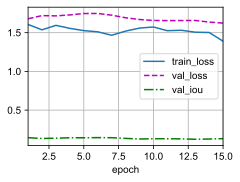

In [139]:
# 使用大小为16的样本先验证可行性
train_model(
    model=model,
    train_dataloader=cake_train_dataloader,
    val_dataloader=cake_val_dataloader,
    num_epochs=15,
)

In [140]:
cake_train_dataloader = get_category_dataloader(
        coco_dataset=train_dataset,
        category_name="cake",
        batch_size=8,  # 由于设备问题，对batch_size=8支持更好
        shuffle=True,
        num_workers=0  # 在Jupyter中设为0避免多进程问题
    )

cake_val_dataloader = get_category_dataloader(
        coco_dataset=val_dataset,
        category_name="cake",
        batch_size=8,
        shuffle=True,
        num_workers=0  # 在Jupyter中设为0避免多进程问题
    )

找到 2925 个包含类别 'cake' 的有效图像
创建了包含2925张'cake'类别图像的数据集
找到 124 个包含类别 'cake' 的有效图像
创建了包含124张'cake'类别图像的数据集


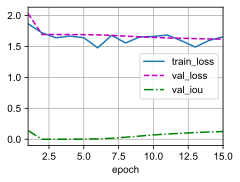

In [141]:
complex_model = NaiveModule()
complex_model.init_weights()
train_model(
    model=complex_model,
    train_dataloader=cake_train_dataloader,
    val_dataloader=cake_val_dataloader,
    num_epochs=15,
)